# Initialization cell

In [ ]:
! pip install python-dotenv
! pip install pymorphy2 nltk scikit-learn
! pip install catboost
! pip install xgboost
! pip install -U scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=3a7761490a4182d66b884a0a764a6602f912b6e392e86885aa1fb7d8e0c586bd
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
import pandas as pd
import numpy as np

import gdown
import os
import json

from dataclasses import dataclass
from typing import Optional
from dotenv import load_dotenv

import pymorphy2
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

nltk.download('punkt')
nltk.download('stopwords')

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline, FunctionTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import make_scorer, mean_squared_error, root_mean_squared_error

from tqdm import tqdm
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Preparation cell

In [ ]:
ROOT_DIR: str = os.path.dirname(os.path.abspath(os.curdir))
DATASET_PATH: str = f"{ROOT_DIR}/source_data/superset_hr.xlsx"
SKILLS_JSON_PATH: str = f"{ROOT_DIR}/source_data/skills_dictionary.json"
GOOGLE_COLAB_PATH: str = '/content/superset_hr.xlsx'

load_dotenv()
SKILL_DICT_URL = os.environ.get('SKILL_DICT_URL')
DATASET_URL = os.environ.get('DATASET_V2_URL')

if DATASET_URL is None:
    print('>>> .env was not found!', end='\n\n')
    DATASET_URL = input('>>> Provide DATASET url for downloading: ')

    if SKILL_DICT_URL is None: SKILL_DICT_URL = input('>>> Provide JSON url for downloading: ')

>>> .env was not found!

>>> Provide DATASET url for downloading: https://docs.google.com/spreadsheets/d/1xlPdrAXvRg0SEZEaCJ6luyzYQjmL8lRd/edit?usp=sharing&ouid=110621792979756403582&rtpof=true&sd=true
>>> Provide JSON url for downloading: https://drive.google.com/file/d/16AByN3AxPvlg3JZKV6T3njo7XJITnr8s/view?usp=sharing


In [ ]:
def get_skill_dict() -> dict[str: list[int]]:
    try:
        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    except FileNotFoundError:
        print(f"Can't open file from path: {SKILLS_JSON_PATH}", end='\n\n')
        file_name = gdown.download(SKILL_DICT_URL, fuzzy=True)
        os.makedirs(os.path.dirname(SKILLS_JSON_PATH), exist_ok=True)
        os.rename(os.path.abspath(file_name), SKILLS_JSON_PATH)
        print(f'Moved to: {SKILLS_JSON_PATH}', end='\n\n')

        with open(file=SKILLS_JSON_PATH, mode='r') as input_json_file:
            data = json.load(input_json_file)
    return data


def get_original_dataframe() -> pd.DataFrame:
    try:
        df = pd.read_excel(DATASET_PATH)
    except FileNotFoundError:
        try:
            print(f"Can't open file from path: {DATASET_PATH}", end='\n\n')
            df = pd.read_excel(GOOGLE_COLAB_PATH)
        except FileNotFoundError:
            print(f"Can't open file from path: {GOOGLE_COLAB_PATH}", end='\n\n')
            file_name = gdown.download(DATASET_URL, fuzzy=True)
            os.makedirs(os.path.dirname(DATASET_PATH), exist_ok=True)
            os.rename(os.path.abspath(file_name), DATASET_PATH)
            print(f'Moved to: {DATASET_PATH}', end='\n\n')
            df = pd.read_excel(DATASET_PATH)
    finally:
        print('Success!')
        return df

In [ ]:
skills_dict = get_skill_dict()

Can't open file from path: //source_data/skills_dictionary.json



Downloading...
From: https://drive.google.com/uc?id=16AByN3AxPvlg3JZKV6T3njo7XJITnr8s
To: /content/skills_dictionary.json
100%|██████████| 458k/458k [00:00<00:00, 58.8MB/s]

Moved to: //source_data/skills_dictionary.json



In [ ]:
df_original = get_original_dataframe()

Can't open file from path: //source_data/superset_hr.xlsx

Can't open file from path: /content/superset_hr.xlsx



Downloading...
From: https://drive.google.com/uc?id=1xlPdrAXvRg0SEZEaCJ6luyzYQjmL8lRd
To: /content/superset_hh_cleaned.xlsx
100%|██████████| 32.1M/32.1M [00:00<00:00, 125MB/s]


Moved to: //source_data/superset_hr.xlsx

Success!


In [ ]:
print(df_original.shape)
df_original.sample(3)

(188833, 21)


,id,income_name,name,published_at,created_at,collected_at,url,area__name,salary__currency,salary__gross,...,address__city,schedule__name,grade,employment__name,key_skills__names,languages__names,exchange_rate,salary_from_gross,salary_to_gross,salary_average
2869,91489747,Бизнес аналитик,Бизнес-аналитик,2024-01-11T18:25:33+0300,2024-01-11T18:25:33+0300,2024-01-27 00:00:00.000,https://api.hh.ru/vacancies/91489747?host=hh.ru,Москва,NaN,NaN,...,Москва,Полный день,Intern (0-1),Полная занятость,[],[],NaN,NaN,NaN,NaN
120646,96602333,Аналитик,Старший кредитный аналитик малого бизнеса,2024-04-10T11:05:00+0300,2024-04-10T11:05:00+0300,2024-04-11 11:04:40.485,https://api.hh.ru/vacancies/96602333?host=hh.ru,Вологда,NaN,NaN,...,NaN,Полный день,Junior (1-3),Полная занятость,[],[],NaN,NaN,NaN,NaN
79638,95637245,Технический писатель,Ведущий технический писатель,2024-03-27T16:06:46+0300,2024-03-27T16:06:46+0300,2024-03-29 12:28:09.898,https://api.hh.ru/vacancies/95637245?host=hh.ru,Казань,NaN,NaN,...,Казань,Полный день,Junior (1-3),Полная занятость,"['Разработка технических заданий', 'ГОСТ', 'Те...",['Английский'],NaN,NaN,NaN,NaN


# Function & utils cell

In [ ]:
def print_df_info(df: pd.DataFrame) -> None:
    print(f"Shape: {df.shape}")
    print('-' * 50)
    display(df.sample(3))
    print('-' * 50)
    display(df.info())


def create_new_cities(df: pd.DataFrame, threshold: int = 75) -> pd.DataFrame:
    df_new = df.copy()

    cities = df_new['area__name'].unique()
    city_counts = df_new['area__name'].value_counts()
    N_rows = df_new.shape[0]
    ratios = {city: city_counts[city] / N_rows for city in cities}

    answer = []
    all_percentage = 0
    sorted_dict = {k: v for k, v in sorted(ratios.items(), key=lambda item: item[1], reverse=True)}
    for label, pct in sorted_dict.items():
        all_percentage += pct * 100
        if all_percentage < threshold:
            answer.append(label)

    df_new.loc[~df_new['area__name'].isin(answer), 'area__name'] = 'Малый город'
    return df_new

def select_professions(df: pd.DataFrame, prof_list = list[str], whitelist = True) -> pd.DataFrame:
    df_new = df.copy()

    if whitelist:
        df_new = df_new[df_new['income_name'].isin(prof_list)]
    else:
        df_new = df_new[~df_new['income_name'].isin(prof_list)]

    return df_new

def get_clear_df_version(df: pd.DataFrame, save_cols = list[str]) -> pd.DataFrame:
    df_new = df[save_cols].copy()

    df_new = df_new.dropna(subset=['salary_from_gross', 'salary_to_gross', 'salary_average'], how='all')
    df_new = df_new.dropna(subset=['income_name'])

    df_new = df_new.drop(['salary__currency', 'exchange_rate'], axis=1)

    return df_new


def get_difference_percentiles(df: pd.DataFrame) -> tuple[float, float, float]:
    filtered_df = df.dropna(subset=['salary_from_gross', 'salary_to_gross']).copy()
    filtered_df.loc[:, 'difference'] = filtered_df['salary_to_gross'] - filtered_df['salary_from_gross']
    condition = filtered_df['difference'] > 0.8 * filtered_df['salary_to_gross']
    filtered_df.loc[condition, ['salary_from_gross', 'difference']] = np.nan

    filtered_df = filtered_df.dropna(subset=['salary_from_gross', 'salary_to_gross'])

    filtered_df = filtered_df[filtered_df['salary_from_gross'] >= 1000]
    filtered_df = filtered_df[filtered_df['salary_to_gross'] >= 10000]

    filtered_df.loc[:, 'difference_ratio'] = np.where(filtered_df['salary_to_gross'] != 0,
                                                      filtered_df['difference'] / filtered_df['salary_to_gross'],
                                                      np.nan)

    perc25 = filtered_df['difference_ratio'].quantile(0.25)
    perc50 = filtered_df['difference_ratio'].quantile(0.50)
    perc75 = filtered_df['difference_ratio'].quantile(0.75)

    return perc25, perc50, perc75


def fill_na_salary(df: pd.DataFrame, coef: int | float) -> pd.DataFrame:
    result_df = df.copy()
    result_df['salary_to_gross'] = result_df['salary_to_gross'].fillna(result_df['salary_from_gross'] / (1-coef))
    result_df['salary_from_gross'] = result_df['salary_from_gross'].fillna(result_df['salary_to_gross'] * (1-coef))
    result_df['salary_average'] = result_df['salary_average'].fillna((result_df['salary_to_gross'] + result_df['salary_from_gross']) / 2)

    result_df[['salary_to_gross', 'salary_from_gross', 'salary_average']] = result_df[['salary_to_gross', 'salary_from_gross', 'salary_average']].astype(float)
    return result_df


def exctract_features(df: pd.DataFrame, drop_param: Optional[str] = None) -> pd.DataFrame:
    df.rename(columns={'income_name': 'income__name'}, inplace=True)
    transformers = [
        ('schedule_name', OneHotEncoder(sparse_output=False, drop=drop_param), ['schedule__name']),
        ('grade', OneHotEncoder(sparse_output=False, drop=drop_param), ['grade']),
        ('income_name', OneHotEncoder(sparse_output=False, drop=drop_param), ['income__name']),
        ('area_name', OneHotEncoder(sparse_output=False, drop=drop_param), ['area__name'])
    ]

    pipeline = Pipeline(steps=[
        ('column_transformer', ColumnTransformer(transformers=transformers, remainder='passthrough'))
    ])

    display(pipeline)

    df_transformed = pipeline.fit_transform(df)
    column_names = pipeline.named_steps['column_transformer'].get_feature_names_out()

    strings_to_replace = ['remainder__','schedule__name_','income__name_', 'area__name_']
    for string in strings_to_replace:
        column_names = [x.replace(string, '') for x in column_names]
    column_names = [x.replace('grade__grade_', 'grade_') for x in column_names]

    df_new = pd.DataFrame(df_transformed, columns=column_names)

    return df_new


def convert_skills(skill_string: str, skills_dict: dict) -> tuple[list[str], list[str]]:
    skill_list = eval(skill_string)
    converted_skills = []
    unconverted_skills = []
    for skill in skill_list:
        found = False
        for main_skill, variations in skills_dict.items():
            if skill in variations:
                converted_skills.append(main_skill)
                found = True
                break
        if not found:
            unconverted_skills.append(skill)

    return converted_skills, unconverted_skills


def preprocess_key_skills(df: pd.DataFrame,
                          s_dict: dict[str: list[str]],
                          with_skills: bool = True,
                          with_grade: bool = True,
                          with_area: bool = True) -> pd.DataFrame:
    df_new = df.copy()

    if with_skills:
        df_new[['skills', 'unconverted_skills']] = df_new['key_skills__names'].apply(
            lambda x: pd.Series(convert_skills(x, s_dict))
        )

    df_new = df_new.drop(['key_skills__names'], axis=1)

    if not with_grade:
        df_new = df_new.drop(columns = df.filter(like='grade').columns, axis=1)

    if not with_area:
        df_new = df_new.drop(columns = df.filter(like='area_name').columns, axis=1)

    return df_new


morph = pymorphy2.MorphAnalyzer()
nltk_stop_words  = set(stopwords.words('russian'))
custom_words = {',', ':', 'работа', 'активный', 'язык', 'навык',
                'деловой', 'ведение', 'проведение', 'презентация', 'грамотный'}
stop_words = nltk_stop_words.union(custom_words)


def tokenize_and_lemmatize(skill_list: list[str]) -> list[str]:
    tokens = []
    for skill in skill_list:
        words = word_tokenize(skill)
        lemmas = [morph.parse(word.lower())[0].normal_form for word in words if word.lower() not in stop_words]
        tokens.extend(lemmas)
    return tokens


def process_skills(df: pd.DataFrame,
                   freq_cutoff: int = 100,
                   add_unprocessed: bool = False) -> pd.DataFrame:
    df_processed = df.copy()

    def prepare_skills(df: pd.DataFrame, col: str) -> pd.DataFrame:
        df_new = df.copy()
        df_new[col] = df_new[col].apply(tokenize_and_lemmatize)
        counts = df_new[col].explode().value_counts()
        frequent = counts[counts >= freq_cutoff].index
        df_new[col] = df_new[col].apply(lambda skills: [skill for skill in skills if skill in frequent])

        return df_new

    if add_unprocessed:
        df_processed = prepare_skills(df_processed, 'skills')
        df_processed = prepare_skills(df_processed, 'unconverted_skills')
        df_processed['skills_plus'] = df_processed['skills'] + df_processed['unconverted_skills']
    else:
        df_processed['skills_plus'] = df_processed['skills']

    df_processed = df_processed[df_processed['skills_plus'].apply(lambda x: len(x) > 0)]

    df_processed = df_processed.drop(['unconverted_skills',
                                      'skills'
                                      ], axis = 1)
    return df_processed


def vectorize_PCA_skills(df: pd.DataFrame, n_components: int = 100,
                         PCA_enable: bool = True, add_unprocessed = False) -> pd.DataFrame:
    df_vect = df.copy()
    if not add_unprocessed:
        vectorizer = TfidfVectorizer(analyzer=lambda x: x)
    else:
        df_vect['skills_plus'] = df_vect['skills_plus'].apply(lambda x: ' '.join(x))
        vectorizer = TfidfVectorizer()

    display(vectorizer)
    skills_tfidf = vectorizer.fit_transform(df_vect['skills_plus'])
    skills_df = pd.DataFrame(skills_tfidf.toarray(), columns=vectorizer.get_feature_names_out())
    df_vect = df_vect.reset_index()

    if PCA_enable:
        pca = PCA(n_components)
        display(pca)
        skills_pca = pca.fit_transform(skills_df)
        skills_pca_df = pd.DataFrame(skills_pca, columns=[f'component_{i+1}' for i in range(skills_pca.shape[1])])
        df_merged = pd.concat([df_vect, skills_pca_df], axis=1)
    else:
        df_merged = pd.concat([df_vect, skills_df], axis=1)

    df_merged = df_merged.drop(['skills_plus', 'index'], axis=1)
    df_merged[['salary_from_gross',
               'salary_to_gross',
               'salary_average']] = df_merged[['salary_from_gross',
                                               'salary_to_gross',
                                               'salary_average']].astype(float)

    return df_merged

# Preprocessing Pipleline

In [ ]:
@dataclass
class PreprocessParams:
    BASIC_TRANSFORM: bool = False
    FREQ_CUTOFF: int = 1000
    DROP_PARAM_ONE_HOT = 'first'
    THRESHOLD_CITIES: int = 50
    PERC_NUMBER: int = 0  # 0 - 25% | 1 - 50% | 2 - 75%
    IS_PCA_ENABLE: bool = False
    N_COMPONENTS: int = 100
    ADD_UNPROCESSED: bool = False
    WITH_SKILLS: bool = True
    WITH_GRADE: bool = True
    WITH_AREA: bool = True
    WHITELIST: bool = False

    def __repr__(self) -> str:
        return (
            f"Preprocess Params:\n"
            f"--------------------------\n"
            f"* {self.FREQ_CUTOFF=}\n"
            f"* {self.THRESHOLD_CITIES=}\n"
            f"* {self.DROP_PARAM_ONE_HOT=}\n"
            f"* {self.PERC_NUMBER=}\n"
            f"* {self.IS_PCA_ENABLE=}\n"
            f"* {self.N_COMPONENTS=}\n"
            f"* {self.ADD_UNPROCESSED=}\n"
            f"* {self.WITH_SKILLS=}\n"
            f"* {self.WITH_GRADE=}\n"
            f"* {self.WITH_AREA=}\n"
        )

SAVE_COLS = ['income_name', 'area__name', 'schedule__name', 'grade',
            'key_skills__names', 'salary__currency',
            'exchange_rate', 'salary_from_gross', 'salary_to_gross', 'salary_average'
]

income_names_to_keep = ['Frontend']
income_names_to_remove = ['1C оператор', '1С эксперт', '1С архитектор', 'Руководитель проектов 1С',
                          '1С методист', '1С администратор', '1C консультант', 'IT Product manager',
                          'Менеджер по продажам', 'Менеджер по работе с клиентами', 'Специалист технической поддержки']
income_names_sales = ['Менеджер по продажам', 'Менеджер по работе с клиентами', 'Специалист технической поддержки']


def get_preprocess_pipeline(params: PreprocessParams) -> Pipeline:
    basic_pipe = Pipeline(steps=[
            ('clear_df', FunctionTransformer(
                func=lambda df: get_clear_df_version(df, SAVE_COLS))),

            ('create_new_cities', FunctionTransformer(
                func=lambda df: create_new_cities(df, params.THRESHOLD_CITIES))),

            ('select_professions', FunctionTransformer(
                func=lambda df: select_professions(df, income_names_to_remove, params.WHITELIST))),

            ('fill_na_salary', FunctionTransformer(
                func=lambda df: fill_na_salary(df, get_difference_percentiles(df)[params.PERC_NUMBER])
            )),

            ('preprocess_key_skills', FunctionTransformer(
                func=lambda df: preprocess_key_skills(df, skills_dict,
                                                      params.WITH_SKILLS,
                                                      params.WITH_GRADE,
                                                      params.WITH_AREA)
            )),

            ], verbose=True).set_output(transform="pandas")

    if params.BASIC_TRANSFORM:
        display (basic_pipe)
        return basic_pipe

    pipe_skill_vectorize = Pipeline(steps=[
        ('process_skills', FunctionTransformer(
                func=lambda df: process_skills(df,
                                               params.FREQ_CUTOFF,
                                               params.ADD_UNPROCESSED),
            )),

        ('vectorize_PCA_skills', FunctionTransformer(
                func=lambda df: vectorize_PCA_skills(df,
                                                     params.N_COMPONENTS,
                                                     params.IS_PCA_ENABLE,
                                                     params.ADD_UNPROCESSED)
            ))

        ],verbose=False).set_output(transform="pandas")

    if params.WITH_SKILLS:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('extract_features', FunctionTransformer(
                func=lambda df: exctract_features(df, params.DROP_PARAM_ONE_HOT))),
            ('skill_vectorize', pipe_skill_vectorize)
        ], verbose=True).set_output(transform="pandas")
    else:
        pipe = Pipeline(steps=[
            ('basic_pipe', basic_pipe),
            ('extract_features', FunctionTransformer(
                func=lambda df: exctract_features(df, params.DROP_PARAM_ONE_HOT))),
        ], verbose=True).set_output(transform='pandas')

    print(params, end='\n\n')
    display(pipe)
    return pipe

In [ ]:
pipe_params = PreprocessParams(WITH_SKILLS=True,
                               WITH_GRADE=True,
                               WITH_AREA=True,
                               IS_PCA_ENABLE=True,
                               BASIC_TRANSFORM=False)

pipeline_preprocess: Pipeline = get_preprocess_pipeline(pipe_params)
df_after_preprocess: pd.DataFrame = pipeline_preprocess.fit_transform(df_original)

if not pipe_params.BASIC_TRANSFORM:
    df_after_preprocess: pd.DataFrame = df_after_preprocess.astype(float)

Preprocess Params:
--------------------------
* self.FREQ_CUTOFF=1000
* self.THRESHOLD_CITIES=50
* self.DROP_PARAM_ONE_HOT='first'
* self.PERC_NUMBER=0
* self.IS_PCA_ENABLE=True
* self.N_COMPONENTS=100
* self.ADD_UNPROCESSED=False
* self.WITH_SKILLS=True
* self.WITH_GRADE=True
* self.WITH_AREA=True




Pipeline(steps=[('basic_pipe',
                 Pipeline(steps=[('clear_df',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7ed5930ceb90>)),
                                 ('create_new_cities',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7ed5930cee60>)),
                                 ('select_professions',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<...
                 FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7ed5930cff40>)),
                ('skill_vectorize',
                 Pipeline(steps=[('process_skills',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7ed5930ceb00>)),
                                 ('vectorize_PCA_skills',
                                  FunctionTransformer(func=<function get_preprocess_pipeline.<locals>.<lambda> at 0x7ed5930cfe20>))]))],
         verbose=True)

[Pipeline] .......... (step 1 of 5) Processing clear_df, total=   0.1s
[Pipeline] . (step 2 of 5) Processing create_new_cities, total=   0.0s
[Pipeline]  (step 3 of 5) Processing select_professions, total=   0.0s
[Pipeline] .... (step 4 of 5) Processing fill_na_salary, total=   0.0s
[Pipeline]  (step 5 of 5) Processing preprocess_key_skills, total=  18.3s
[Pipeline] ........ (step 1 of 3) Processing basic_pipe, total=  18.5s


Pipeline(steps=[('column_transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('schedule_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['schedule__name']),
                                                 ('grade',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['grade']),
                                                 ('income_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['income__name']),
                                                 ('area_name',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['area__name'])]))])

[Pipeline] .. (step 2 of 3) Processing extract_features, total=   0.1s


TfidfVectorizer(analyzer=<function vectorize_PCA_skills.<locals>.<lambda> at 0x7ed592fc3910>)

PCA(n_components=100)

[Pipeline] ... (step 3 of 3) Processing skill_vectorize, total=   0.8s


In [ ]:
print_df_info(df_after_preprocess)

Shape: (18119, 135)
--------------------------------------------------


,schedule_name__Гибкий график,schedule_name__Полный день,schedule_name__Сменный график,schedule_name__Удаленная работа,grade_Junior (1-3),grade_Middle (3-6),grade_Senior (>6),income_name__1С программист,income_name__Backend,income_name__Data Analyst,...,component_91,component_92,component_93,component_94,component_95,component_96,component_97,component_98,component_99,component_100
17364,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,-0.123732,-0.153608,0.045629,-0.005020,-0.091750,-0.000367,-0.082506,0.026482,0.029260,0.082009
15472,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.024108,0.006662,0.033660,0.014805,0.013515,-0.002544,0.017102,0.003526,0.005606,0.000916
14554,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-0.018912,-0.005929,0.001096,-0.018231,0.006652,0.002909,-0.013329,-0.012617,-0.006437,0.003460


--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18119 entries, 0 to 18118
Columns: 135 entries, schedule_name__Гибкий график to component_100
dtypes: float64(135)
memory usage: 18.7 MB


None

# Fitting Model

In [ ]:
RANDOM_STATE = 42

param_grid = [
        {
            'model': [Ridge(random_state=RANDOM_STATE)]
        },
        {
            'model': [CatBoostRegressor(verbose=False,
                                        random_state=RANDOM_STATE)]
        },
        {
            'model': [XGBRegressor(random_state=RANDOM_STATE)]
        },
        {
            'model': [RandomForestRegressor(verbose=False, n_jobs=-1, random_state=RANDOM_STATE)]
        },
        {
            'model': [DecisionTreeRegressor(random_state=RANDOM_STATE,
                                            criterion='friedman_mse')]
        }
]

rmse = make_scorer(root_mean_squared_error)
mse = make_scorer(mean_squared_error)

def pipeline_train(data):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])
    y = data['salary_average']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)

    best_models = {}

    for model_params in tqdm(param_grid):
        pipeline = Pipeline(steps=[
            ('model', model_params['model'])
        ])

        grid_search = GridSearchCV(pipeline, param_grid=model_params, cv=5, scoring=rmse)
        display(grid_search)
        grid_search.fit(X_train, y_train)

        y_pred = grid_search.predict(X_test)

        best_models[type(model_params['model']).__name__] = grid_search.best_estimator_
        print(f"Best parameters for {type(model_params['model']).__name__}: {grid_search.best_params_}")
        print(f"Best score for {type(model_params['model']).__name__}: {grid_search.best_score_}")

    return best_models

In [ ]:
# results = pipeline_train(df_after_preprocess)

In [ ]:
import matplotlib.pyplot as plt

def train(data, estimator, n_top_features=40):
    X = data.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'], axis=1)
    y = data['salary_average']
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=RANDOM_STATE, test_size=0.2)
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print(root_mean_squared_error(y_test, y_pred))


    importances = estimator.feature_importances_
    indices = np.argsort(importances)[::-1]
    top_indices = indices[:n_top_features]
    top_importances = importances[top_indices]
    top_features = X.columns[top_indices]

    plt.figure(figsize=(10, 6))
    plt.title('Feature Importances')
    plt.bar(range(n_top_features), top_importances, align='center')
    plt.xticks(range(n_top_features), top_features, rotation=90)
    plt.xlim([-1, n_top_features])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

    return estimator

35406.854191328035


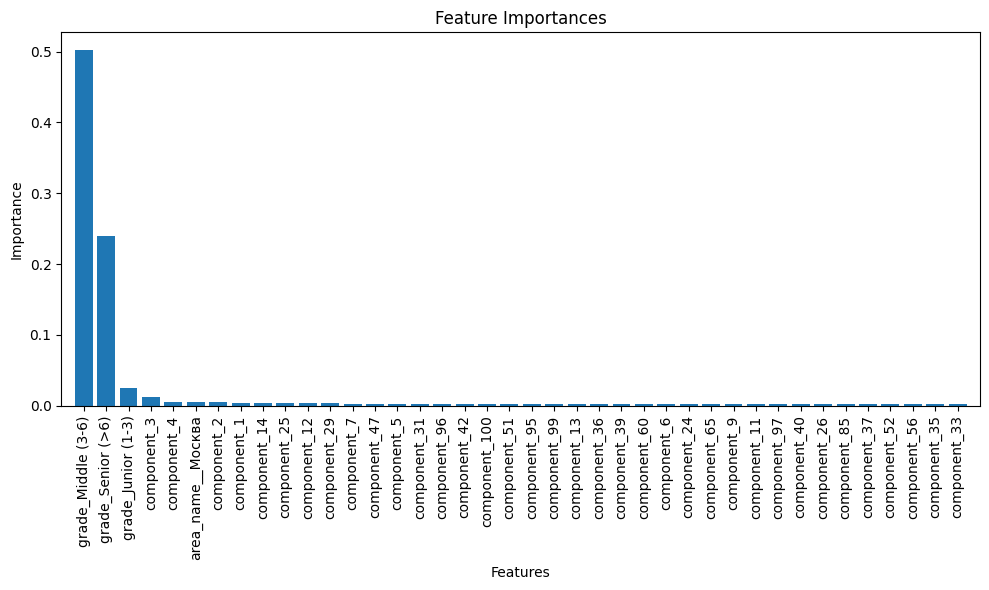

In [ ]:
pretrained_model = train(df_after_preprocess, RandomForestRegressor(n_jobs=-1, random_state=RANDOM_STATE))

# Test Prediction

In [ ]:
def predict_random_from_category(model, data, num_samples = 3, category = None):

    if category == None:
        category = input('>>> Provide category for testing: ')

    for x in range(num_samples):

        random_cat_row = data[data[category] == 1].sample()

        true_salary = random_cat_row['salary_average'].item()
        true_low = random_cat_row['salary_from_gross'].item()
        true_high = random_cat_row['salary_to_gross'].item()

        X_sample = random_cat_row.drop(columns=['salary_from_gross', 'salary_to_gross', 'salary_average'])

        predicted_salary = model.predict(X_sample)[0]
        predicted_low = predicted_salary * 8 / 9
        predicted_low = int(np.round(predicted_low, -2))
        predicted_high = predicted_salary * 10 / 9
        predicted_high = int(np.round(predicted_high, -2))

        print(f"Истинная зарплата для случайной вакансии {x} в категории {category}:\n{true_low} -- {true_high}, среднее {true_salary}\n")
        print(f"Предсказанная зарплата:\n{predicted_low} -- {predicted_high}, среднее {predicted_salary}\n")
        print("____________________________________________________________________________________________\n")

In [ ]:
predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Middle (3-6)')

Истинная зарплата для случайной вакансии 0 в категории grade_Middle (3-6):
230925.0 -- 461850.0, среднее 346387.5

Предсказанная зарплата:
291100 -- 363900, среднее 327496.37842460314

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Middle (3-6):
230000.0 -- 320000.0, среднее 275000.0

Предсказанная зарплата:
244400 -- 305600, среднее 275000.0

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Middle (3-6):
169500.0 -- 226000.0, среднее 197750.0

Предсказанная зарплата:
249300 -- 311600, среднее 280472.937672619

____________________________________________________________________________________________



In [ ]:
predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Junior (1-3)')

Истинная зарплата для случайной вакансии 0 в категории grade_Junior (1-3):
84749.99999999999 -- 113000.0, среднее 98874.99999999999

Предсказанная зарплата:
92200 -- 115300, среднее 103768.12214285713

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Junior (1-3):
135600.0 -- 158199.99999999997, среднее 146900.0

Предсказанная зарплата:
124900 -- 156100, среднее 140500.08273809525

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Junior (1-3):
115000.0 -- 134166.66666666663, среднее 124583.33333333331

Предсказанная зарплата:
113400 -- 141800, среднее 127616.47083333333

____________________________________________________________________________________________



In [ ]:
predict_random_from_category(pretrained_model, df_after_preprocess, category = 'grade_Senior (>6)')

Истинная зарплата для случайной вакансии 0 в категории grade_Senior (>6):
254250.0 -- 338999.9999999999, среднее 296625.0

Предсказанная зарплата:
266800 -- 333500, среднее 300165.6666666667

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 1 в категории grade_Senior (>6):
232780.0 -- 279336.0, среднее 256058.0

Предсказанная зарплата:
221100 -- 276400, среднее 248715.56319047618

____________________________________________________________________________________________

Истинная зарплата для случайной вакансии 2 в категории grade_Senior (>6):
369480.0 -- 508035.0, среднее 438757.5

Предсказанная зарплата:
386200 -- 482800, среднее 434501.32242857135

____________________________________________________________________________________________



In [ ]:
import pickle

with open('model.pkl','wb') as f:
    pickle.dump(pretrained_model, f)